In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from visual_genome.local import VisualGenome
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
import pandas as pd
from nltk.cluster import KMeansClusterer
from sentence_transformers import SentenceTransformer
from nltk.cluster import KMeansClusterer
from scipy.spatial import distance_matrix, distance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Sample images from the dataset, save them to a txt file called `ids.txt` line by line. Then read the file and create the corresponding csv file below.


In [2]:
vg = VisualGenome()

Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data
Loading data...
Data loaded.


In [6]:
ids = vg.get_all_image_ids()

In [ ]:
# read filtered_images_2.txt

with open('filtered_images_2.txt', 'r') as f:
    filtered_images = f.readlines()

ids = vg.get_all_image_ids()
test_ids = [int(i) for i in filtered_images]
remaining_ids = [i for i in ids if i not in test_ids]

# split the remaining ids into validation and training (5000 for validation, rest for training

np.random.seed(0)
np.random.shuffle(remaining_ids)

val_ids = remaining_ids[:5000]
train_ids = remaining_ids[5000:]

len(val_ids), len(train_ids), len(test_ids)

# read data.csv and add category column (val, train or test)

data = pd.read_csv('data.csv')
data['category'] = 'train'
data.loc[data['image_id'].isin(val_ids), 'category'] = 'val'
data.loc[data['image_id'].isin(test_ids), 'category'] = 'test'

data.to_csv('data.csv', index=False)

In [5]:
regions = []
images = vg.get_images()
for id in ids:
    image_regions = images[id]["regions"]
    region_sentences = []

    for region in image_regions:
        region_sentences.append(region.phrase.lower())
    regions.append(region_sentences)

images_regions = pd.DataFrame(list(zip(ids, regions)), columns =['Image_id', 'region_sentences'])
images_regions.to_csv('image_regions.csv', index=False)

### Sentence Transformer

For now, I'll use `all-mpnet-base-v2`. This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search. 

Source: https://sbert.net/docs/sentence_transformer/pretrained_models.html

TODO: Check other models in the leaderboard: https://huggingface.co/spaces/mteb/leaderboard  (Look for clustering) \
Maybe we can go for bigger models to get better clusters?

`all-mpnet-base-v2`: Rank 80 for clustering (17/09/24). Average score: 43.69 (109M params) \
`Alibaba-NLP/gte-large-en-v1.5`: Rank 20 for clustering (17/09/24). Average score: 47.96 - (434M params)



In [35]:
models = [
    'all-mpnet-base-v2',  # approx 8 min to load the model
    'gte-large-en-v1.5',  # approx 17 min to load the model
]
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # takes approx 5 min to load

# model = SentenceTransformer("all-mpnet-base-v2", trust_remote_code=True).cuda()
model_name = 'all-mpnet-base-v2'

c:\Users\karab\Desktop\Visual Genome Driver\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
import torch
torch.cuda.is_available()

True

In [37]:
def get_embeddings(model, region_sentences):
    sentence_embeddings = model.encode(region_sentences)
    return sentence_embeddings

image_regions_csv = pd.read_csv("image_regions.csv")
image_regions_csv.head()

,Image_id,region_sentences
0,1,"['the clock is green in colour', 'shade is alo..."
1,2,"['walk sign is lit up', 'man wearing silver ba..."
2,3,"['multi-line office phone system', 'electrical..."
3,4,"['blue curtains with sailboats on them.', 'a b..."
4,5,"['the floor is wooden', 'white cables are on t..."


In [38]:
image_regions_csv["region_sentences"] = image_regions_csv["region_sentences"].apply(eval)
regions = image_regions_csv["region_sentences"].tolist()

In [39]:
len(regions) # all images

108077

### Get Embeddings

In [40]:
embeddings = []
for image_regions in regions:
    # returns a list of lists, one 768-length embedding per region sentence. 
    # Number of rows corresponds to number of sentences

    # image_regions: list of regions for the same image
    if image_regions:
        emb = get_embeddings(model, image_regions)
        # get mean value columnwise, so that sentence embeddings are averaged per region for each image
        emb = np.mean(np.array(emb), axis=0) 
        # for each model, a 768-length embedding is stored
        embeddings.append(emb)
    else:
        embeddings.append(0)
len(embeddings)  # takes approx 8 min to run

108077

In [41]:
image_regions_csv["embeddings"] = pd.Series(embeddings, index=image_regions_csv.index)  # add embeddings to the csv

In [66]:
image_regions_csv.head()

,Image_id,region_sentences,embeddings
0,1,"[the clock is green in colour, shade is along ...","[-0.0022422066, -0.012550487, 0.006492141, 0.0..."
1,2,"[walk sign is lit up, man wearing silver backp...","[-0.0074147964, -0.015363234, 0.0065151993, 0...."
2,3,"[multi-line office phone system, electrical an...","[0.012363321, -0.025192637, 0.008693925, 0.014..."
3,4,"[blue curtains with sailboats on them., a blac...","[0.0072458126, -0.019052038, -0.006049682, 0.0..."
4,5,"[the floor is wooden, white cables are on the ...","[0.003319924, -0.020315787, 0.0074892957, 0.01..."


In [69]:
def cluster(images_regions_csv, num_clusters):
    sentences = images_regions_csv['region_sentences']
    X = np.array(images_regions_csv["embeddings"].tolist())

    data = images_regions_csv[['Image_id', 'region_sentences', "embeddings"]].copy()
    kclusterer = KMeansClusterer(
        num_clusters, distance=nltk.cluster.util.cosine_distance,
        avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(data["embeddings"], assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row["embeddings"]], [row['centroid'].tolist()])[0][0]

In [70]:
def nltk_inertia(feature_matrix, centroid):
    sum_ = []
    for i in range(feature_matrix.shape[0]):
        sum_.append(np.sum((feature_matrix[i] - centroid[i])**2))  
    return sum(sum_) 

def number_of_clusters(image_regions_csv, model_name):
    sse = [] # sum of squared distance
    list_k = list(range(10, 300, 10))

    for k in list_k:
        data, assigned_clusters = cluster(image_regions_csv, k)
        sse.append(nltk_inertia(data["embeddings"].to_numpy(), data.centroid.to_numpy()))

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.title('Elbow method for '+ model_name)
    plt.plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters k')
    plt.ylabel('Sum of squared distance')
    plt.show()

In [45]:
# Elbow method does not seem to be a good metric to measure cluster quality due to "curse of dimensionality" - prone to overfitting
# number_of_clusters(image_regions_csv, model_name) # it takes 80 mins for range(10, 300)

In [71]:
n_clusters = 80

def make_clusters(images_regions, n_clusters):
    data, assigned_clusters = cluster(images_regions, n_clusters)
    # Compute centroid distance to the data
    data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)
    return data

In [72]:
def tsne_visual(embedding_clusters, model_name):
    mat = np.asarray([x for x in embedding_clusters["embeddings"]])
    t_sne = TSNE(n_components=2)
    low_dim_data = t_sne.fit_transform(mat)
    print('Lower dim data has shape',low_dim_data.shape)
    tsne_df =  pd.DataFrame(low_dim_data, embedding_clusters['cluster'])
    plt.figure(figsize=(20,12))
    
    # tsne_df - 10000 x 2
    sns.set(rc={"figure.figsize":(12, 16)})
    ax = sns.scatterplot( x=tsne_df[0], y=tsne_df[1], hue=tsne_df.index, palette = "viridis", s=80)
    ax.set_title('T-SNE BERT Embeddings for '+ model_name)
    plt.show()
    return low_dim_data


In [73]:
embedding_clusters=make_clusters(image_regions_csv, n_clusters) # takes approx 12 seconds
embedding_clusters.head(5)

,Image_id,region_sentences,embeddings,cluster,centroid,distance_from_centroid
0,1,"[the clock is green in colour, shade is along ...","[-0.0022422066, -0.012550487, 0.006492141, 0.0...",38,"[0.0026866363, -0.021766406, 0.004537341, 0.02...",0.201066
1,2,"[walk sign is lit up, man wearing silver backp...","[-0.0074147964, -0.015363234, 0.0065151993, 0....",55,"[-0.0004988932, -0.021391606, 0.0017798932, 0....",0.223405
2,3,"[multi-line office phone system, electrical an...","[0.012363321, -0.025192637, 0.008693925, 0.014...",66,"[0.017282354, -0.04727607, 0.0049175313, 0.012...",0.194000
3,4,"[blue curtains with sailboats on them., a blac...","[0.0072458126, -0.019052038, -0.006049682, 0.0...",16,"[0.01431401, -0.030943092, -0.00042980196, 0.0...",0.190350
4,5,"[the floor is wooden, white cables are on the ...","[0.003319924, -0.020315787, 0.0074892957, 0.01...",16,"[0.01431401, -0.030943092, -0.00042980196, 0.0...",0.221502


In [74]:
# save embedding_clusters
csv_name = "categories_{}_{}clusters.csv".format(model_name, n_clusters)
embedding_clusters.to_csv(csv_name, index=False)

# save only image ids and clusters
image_clusters = embedding_clusters[['Image_id', 'cluster']]
image_clusters.to_csv("categories_{}_{}clusters_simple.csv".format(model_name, n_clusters), index=False)

In [75]:
def find_distances(images_regions_csv, input_id, input_embedding = np.zeros(5)):
    distances = []     
    image_ids = images_regions_csv.Image_id
    if input_id > 0:
        reference_embedding = images_regions_csv.loc[images_regions_csv.Image_id == input_id]["embeddings"]
        reference_embedding = reference_embedding.values[0].reshape(-1,1)
        corpus_embeddings = images_regions_csv.loc[images_regions_csv.Image_id != input_id]["embeddings"]
    else:
        reference_embedding = input_embedding
        corpus_embeddings = images_regions_csv["embeddings"]
        
    for j in range(len(corpus_embeddings)):  # rows of def_embeddings matrix
        defin = j
        if image_ids[j]!=input_id:      # avoid calculating distance with itself
            corpus = corpus_embeddings[j].reshape(-1,1)
            # euclidean distance between multidimensional vectors
            dist = distance.euclidean(reference_embedding, corpus)
            distances.append([image_ids[j], dist]) 
        
    # store in df
    col_names = ['image_id', 'distances']
    distances_df = pd.DataFrame(distances, columns=col_names)
    distances_df = distances_df.sort_values(by='distances', ascending=True)
    distances_df.to_csv('distances.csv', index=False)
    return distances_df

# given image id to retrieve its k most similar images
def retrieve_images(model_name, image_regions_csv, input_id = -1, input_embedding = np.zeros(5)):
    print('Images retrieved using method:', model_name)
    top_k = 10
    
    if input_id > 0:
    # top_k results to return
        print('Reference image:', input_id)
        vg.visualize_regions(input_id, 0)
        distances_df = find_distances(image_regions_csv, input_id)
    else:
        distances_df = find_distances(image_regions_csv, input_id, input_embedding)
    top_images=distances_df.head(top_k)

    print("Top", top_k, "most similar images to image", input_id, "in Visual Genome:")
    for _, row in top_images.iterrows():   
        im_id = int(row.image_id)
        print("Image id:", im_id, "Euclidean distance: %.4f" % (row.distances))

        # find similar images from api and show
        vg.visualize_regions(input_id, 0)

    return top_images

Lower dim data has shape (108077, 2)


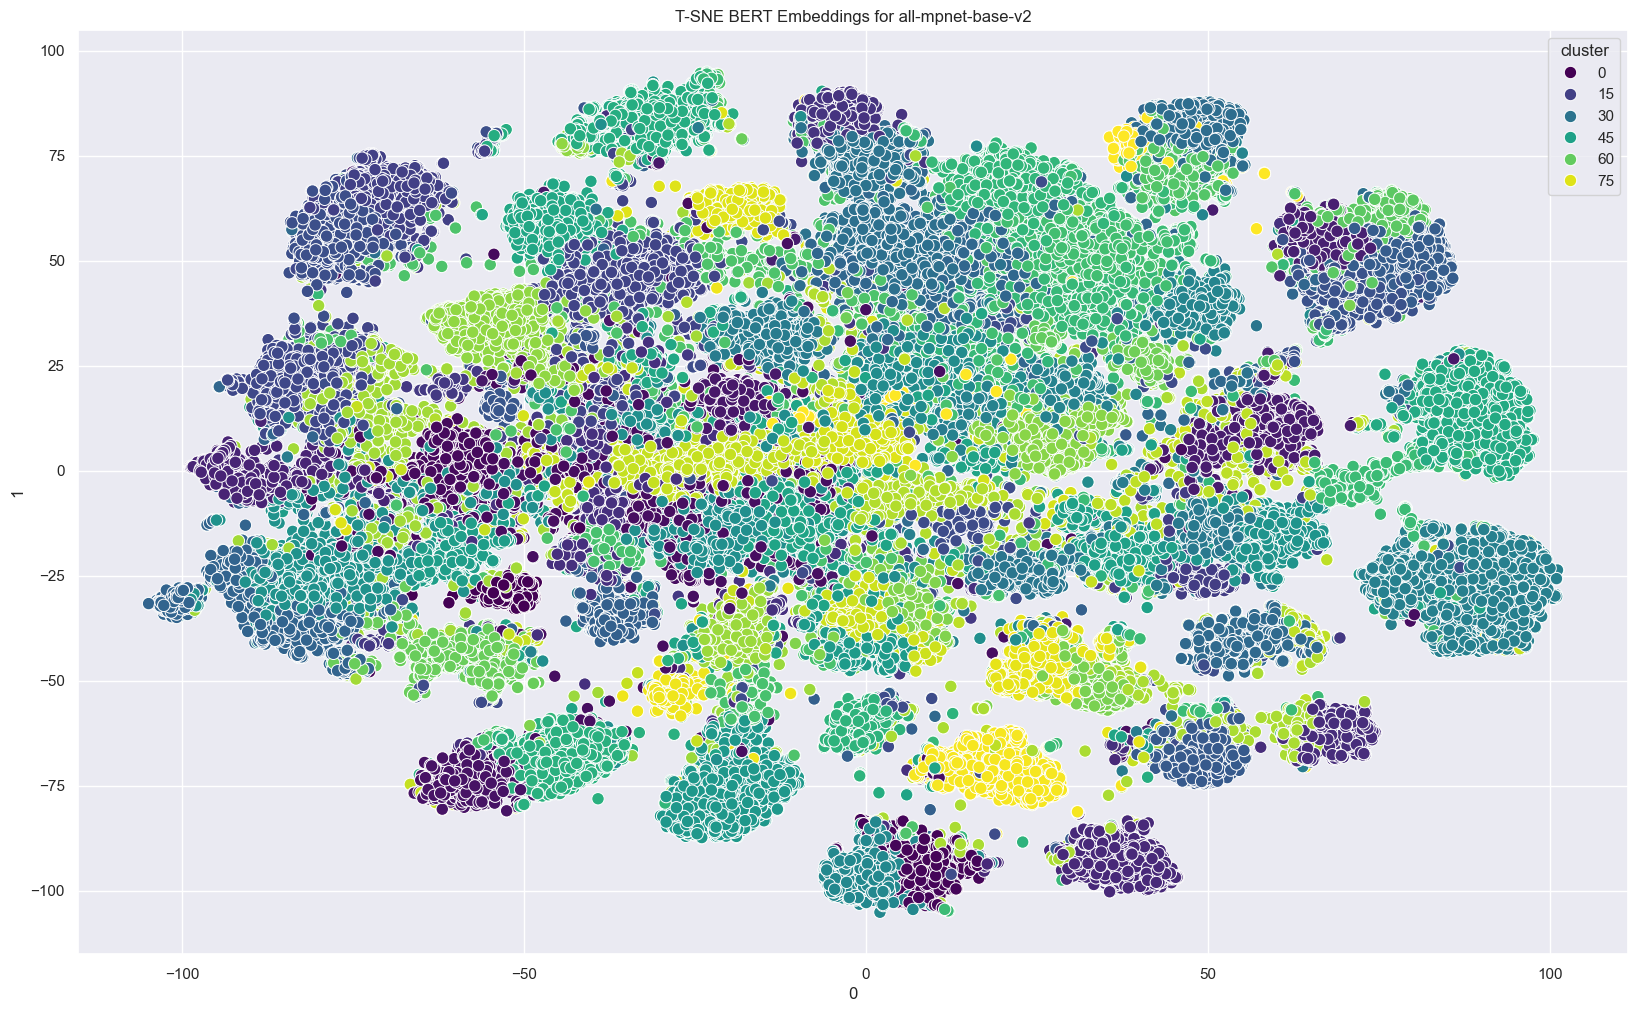

In [76]:
low_embedding_clusters =  tsne_visual(embedding_clusters, model_name)  # takes approx. 

0.15854111


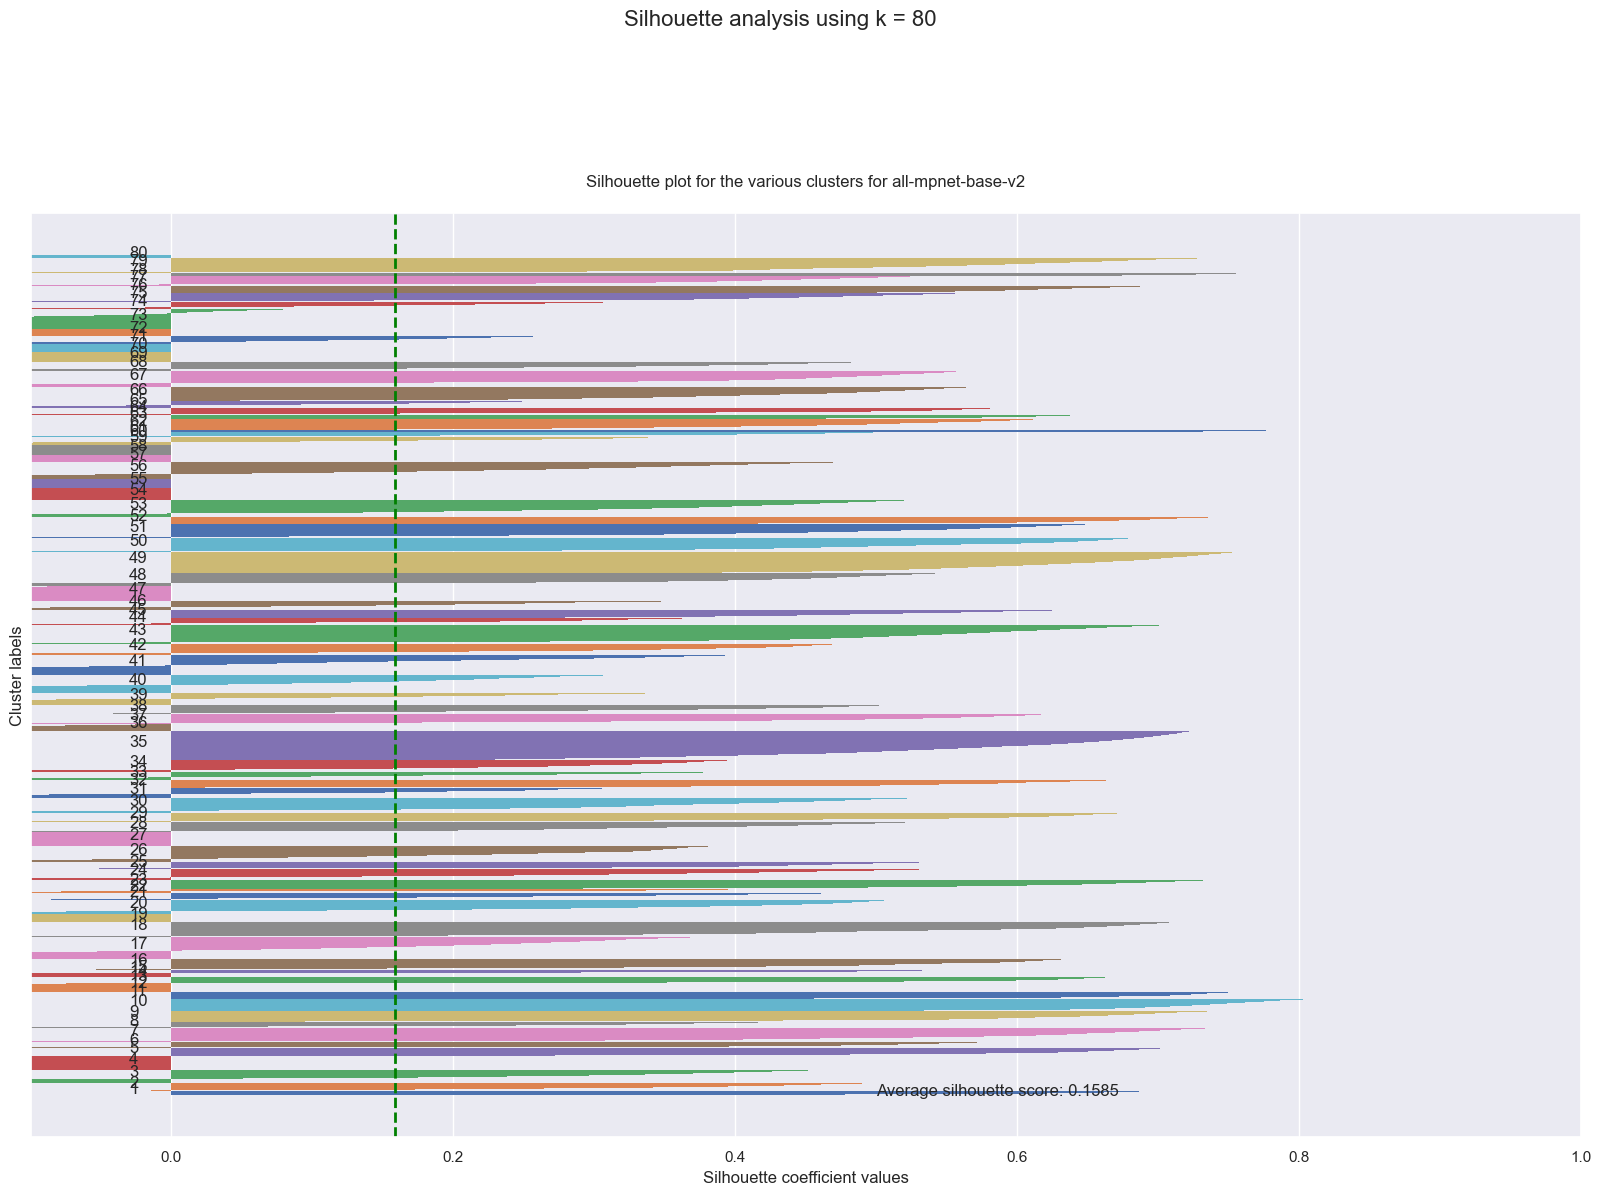

In [77]:
from sklearn.metrics import silhouette_samples

# Get silhouette samples
low_embedding_clusters = low_embedding_clusters
embedding_clusters=embedding_clusters

plt.figure(figsize=(20,12))

embedding_samples = low_embedding_clusters
labels = embedding_clusters['cluster'].to_numpy()
silhouette_vals = silhouette_samples(embedding_samples, labels)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)


avg_score = np.mean(silhouette_vals)
print(avg_score)
plt.axvline(avg_score, linestyle='--', linewidth=2, color='green')
plt.yticks([])
plt.xlim([-0.1, 1])
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster labels')
plt.title(f'Silhouette plot for the various clusters for {model_name}', y=1.02);
plt.text(0.5, 0.5, 'Average silhouette score: %.4f' % avg_score, fontsize=12)


plt.suptitle(f'Silhouette analysis using k = {n_clusters}',
             fontsize=16, y=1.05)
# save silhouette plot
plt.savefig(f'silhouette_plot_{model_name}_{n_clusters}clusters.png')
plt.show()



In [78]:
# read cluster csv
embedding_clusters = pd.read_csv(csv_name)
embedding_clusters.head()

,Image_id,region_sentences,embeddings,cluster,centroid,distance_from_centroid
0,1,"['the clock is green in colour', 'shade is alo...",[-2.24220660e-03 -1.25504872e-02 6.49214117e-...,38,[ 2.68663629e-03 -2.17664056e-02 4.53734118e-...,0.201066
1,2,"['walk sign is lit up', 'man wearing silver ba...",[-7.41479639e-03 -1.53632341e-02 6.51519932e-...,55,[-4.98893205e-04 -2.13916060e-02 1.77989318e-...,0.223405
2,3,"['multi-line office phone system', 'electrical...",[ 1.23633211e-02 -2.51926370e-02 8.69392511e-...,66,[ 1.72823537e-02 -4.72760685e-02 4.91753127e-...,0.194000
3,4,"['blue curtains with sailboats on them.', 'a b...",[ 7.24581257e-03 -1.90520380e-02 -6.04968192e-...,16,[ 1.43140098e-02 -3.09430920e-02 -4.29801963e-...,0.190350
4,5,"['the floor is wooden', 'white cables are on t...",[ 3.31992400e-03 -2.03157868e-02 7.48929568e-...,16,[ 1.43140098e-02 -3.09430920e-02 -4.29801963e-...,0.221502


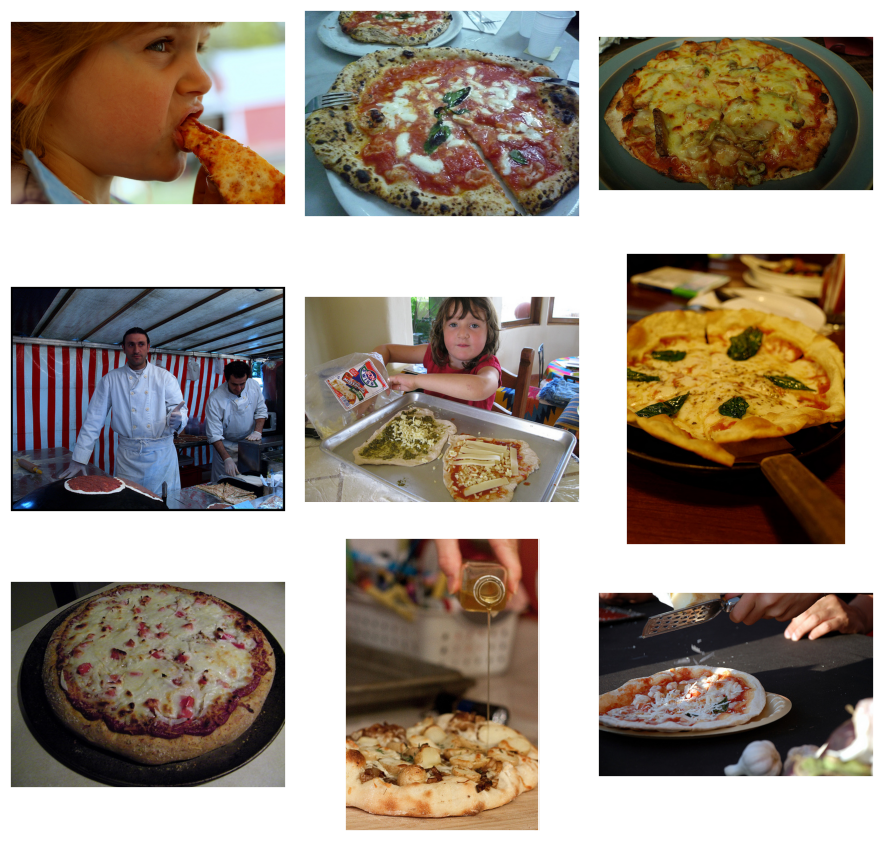

In [79]:
vg.visualize_cluster(embedding_clusters, cluster = 8, n = 3)